# Проект "Анализ бизнес показателей"

### Описание проекта

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
 - лог сервера с данными об их посещениях,
 - выгрузка их покупок за этот период,
 - рекламные расходы.

Вам предстоит изучить:
 - откуда приходят пользователи и какими устройствами они пользуются,
 - сколько стоит привлечение пользователей из различных рекламных каналов;
 - сколько денег приносит каждый клиент,
 - когда расходы на привлечение клиента окупаются,
 - какие факторы мешают привлечению клиентов.

**Описание данных**

В вашем распоряжении три датасета. 
 - Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, 
 - orders_info_short.csv — информацию о заказах, 
 - costs_info_short.csv — информацию о расходах на рекламу.

Структура visits_info_short.csv:
 - User Id — уникальный идентификатор пользователя,
 - Region — страна пользователя,
 - Device — тип устройства пользователя,
 - Channel — идентификатор источника перехода,
 - Session Start — дата и время начала сессии,
 - Session End — дата и время окончания сессии.

Структура orders_info_short.csv:
 - User Id — уникальный идентификатор пользователя,
 - Event Dt — дата и время покупки,
 - Revenue — сумма заказа.
 
Структура costs_info_short.csv:
 - dt — дата проведения рекламной кампании,
 - Channel — идентификатор рекламного источника,
 - costs — расходы на эту кампанию.

### Загрузим данные и подготовим их к анализу

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [1]:
import pandas as pd #импортируем все необходимые библиотеки
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv') #загрузим данные
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
visits.info() #посмотрим общую информацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Пропусков нет. Но столбцы лучше переименовать. И поменять в двух столбцах тип данных на datetime

In [4]:
visits.columns = visits.columns.str.lower() #переведем названия колонок в нижний регистр
visits = visits.rename( #переименуем колонки
    columns={
        'user id': 'user_id',
        'session start': 'session_start',
        'session end': 'session_end'
    }
)

In [5]:
visits['session_start'] = pd.to_datetime(visits['session_start']) #переведем данные столбцов в тип datetime
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [6]:
orders.info() #проведем аналогичные действия с остальными таблицами

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Пропусков нет. Но столбцы лучше переименовать. И поменять в одном столбце тип данных на datetime

In [7]:
orders.columns = orders.columns.str.lower()
orders = orders.rename(
    columns={
        'user id': 'user_id',
        'event dt': 'event_dt'
    }
)

In [8]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [9]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Пропусков нет. Но второй столбец нужно переименовать, а в первом поменять тип данных на datetime

In [10]:
costs = costs.rename(columns={'Channel': 'channel'})

In [11]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Проверим на наличие явных дубликатов

In [12]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


Дубликатов нет

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

**Функции для вычисления значений метрик**

In [13]:
# функция для создания пользовательских профилей get_profiles()

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [14]:
# функция для расчёта удержания get_retention()

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [15]:
# функция для расчёта конверсии get_conversion()

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [16]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

**Функции для построения графиков**

In [17]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [18]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    #plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    #plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [19]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    #plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [20]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    #plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    #plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

Получим профили пользователей. Для этого вызовем функцию get_profiles(), передав ей данные о посещениях, покупках, и тратах на рекламу 

In [21]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Установим момент и горизонт анализа данных, а также максимальную и минимальную даты привлечения пользователей

In [22]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14 # горизонт анализа 
last_suitable_acquisition_date = observation_date - timedelta( #максимальная дата привлечения пользователей
        days=horizon_days - 1
    )
print('Максимальная дата привлечения пользователей:', last_suitable_acquisition_date)
print()
print('Минимальная дата привлечения пользователей:',\
      profiles['first_ts'].min().date()) #минимальная дата привлечения пользователей)

Максимальная дата привлечения пользователей: 2019-10-19

Минимальная дата привлечения пользователей: 2019-05-01


Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [23]:
pd.set_option('display.float_format', '{:.2f}'.format)
profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'mean' })

,user_id,payer
region,,
France,17450,0.04
Germany,14981,0.04
UK,17575,0.04
United States,100002,0.07


Больше всего пользователей приходит из США. Доля платящих пользователей из США тоже выше. Количество платящих пользователей из Великобритании и Франции ниже чем в Германии, однако количество привлеченных пользователей из двух указанных стран выше чем в Германии

Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [24]:
profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'mean'})

,user_id,payer
device,,
Android,35032,0.06
Mac,30042,0.06
PC,30455,0.05
iPhone,54479,0.06


Клиенты предпочитают пользоваться iPhone. Однако максимальное количество платящих пользоватетелей - это обладатели Мас

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [25]:
profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='user_id', ascending=False)

,user_id,payer
channel,,
organic,56439,0.02
FaceBoom,29144,0.12
TipTop,19561,0.10
OppleCreativeMedia,8605,0.03
LeapBob,8553,0.03
WahooNetBanner,8553,0.05
RocketSuperAds,4448,0.08
MediaTornado,4364,0.04
YRabbit,4312,0.04


- Больше всего потенциальных клиентов - это "органические" пользователи. Однако, количество совершивших покупки среди этих пользователей - самое низкое.
- Каналы - AdNonSense, lambdaMediaAds - привели меньше всего пользователей, однако среди них высокая доля платящих пользователей.
- Каналы FaceBoom	и TipTop привели больше всего пользователей среди платных каналов, доля платящих пользователей там тоже высока.

### Маркетинг

Посчитаем общую сумму расходов на маркетинг

In [26]:
profiles['acquisition_cost'].sum() #общая сумма расходов на маркетинг

105497.29999999999

Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [27]:
profiles.groupby('channel').agg({'acquisition_cost': 'sum'}).sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Самые высокие траты - это TipTop, однако пользователей от этого источника приходит меньше чем от FaceBoom, траты на который значительно меньше.

Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

In [28]:
profiles_tip_face = profiles.query('channel in ("TipTop", "FaceBoom")')
profiles_not_tip_face = profiles.query('channel not in ("TipTop", "FaceBoom")')

In [29]:
prof = profiles[['first_ts', 'channel', 'acquisition_cost']].copy() #Создадим новую таблицу
prof['week'] = prof['first_ts'].dt.isocalendar().week #добавим столбец с номером недели
prof['month'] = prof['first_ts'].dt.month #добавим столбец с номером месяца
prof = prof.query('channel != "organic"') #удалим "органических" пользователей
prof.pivot_table(index='month', columns='channel', values='acquisition_cost', aggfunc='sum')

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
month,,,,,,,,,,
5,1169.70,3524.40,140.28,238.56,169.75,577.98,2981.00,418.80,299.70,458.40
6,538.65,5501.10,314.58,138.00,370.00,325.71,6675.60,921.00,106.20,199.20
7,504.00,5294.30,313.53,138.48,366.50,252.07,8410.20,851.40,97.38,219.20
8,579.60,6274.40,369.81,154.56,439.25,253.11,11202.00,1040.40,124.74,220.00
9,581.70,6114.90,343.98,144.72,427.75,218.40,13232.50,977.40,152.79,247.20
10,537.60,5736.50,315.42,140.16,378.00,205.73,12250.00,942.00,163.41,213.60


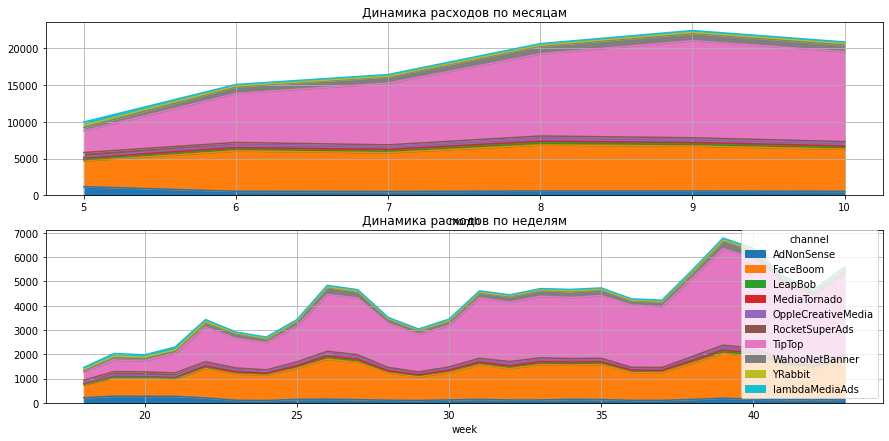

In [30]:
ax1 = plt.subplot(2, 1, 1) #строим графики
prof.pivot_table(index='month', columns='channel', values='acquisition_cost', aggfunc='sum')\
.plot(kind='area', stacked = True, figsize=(15, 7), grid=True, ax=ax1, legend=False)

plt.title('Динамика расходов по месяцам')

ax2 = plt.subplot(2, 1, 2)
prof.pivot_table(index='week', columns='channel', values='acquisition_cost', aggfunc='sum' )\
.plot(kind='area', stacked = True, figsize=(15, 7), grid=True, ax=ax2)

plt.title('Динамика расходов по неделям')
plt.show()

С мая по октябрь наблюдается увеличение расходов на TipTop. Уменьшились траты на AdNonSense, на канал, который привносит много платящих пользователей. Траты на канал FaceBoom без особых изменений. По другим каналам вывод сделать трудно, значения небольшие, изменений не видно.

Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Будем использовать для этого профили пользователей.

In [31]:
profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')\
.sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Привлечение одного пользователя из TipTop обходится компании в 2,8 доллара, из FaceBoom - в 1,1 доллар.

### Оценим окупаемость рекламы

Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi(). Исключим органических пользователей, чтобы не смазывали показатели.

In [32]:
profiles_no_org = profiles.query('channel != "organic"')

In [33]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_org,
    orders,
    observation_date,
    horizon_days
)

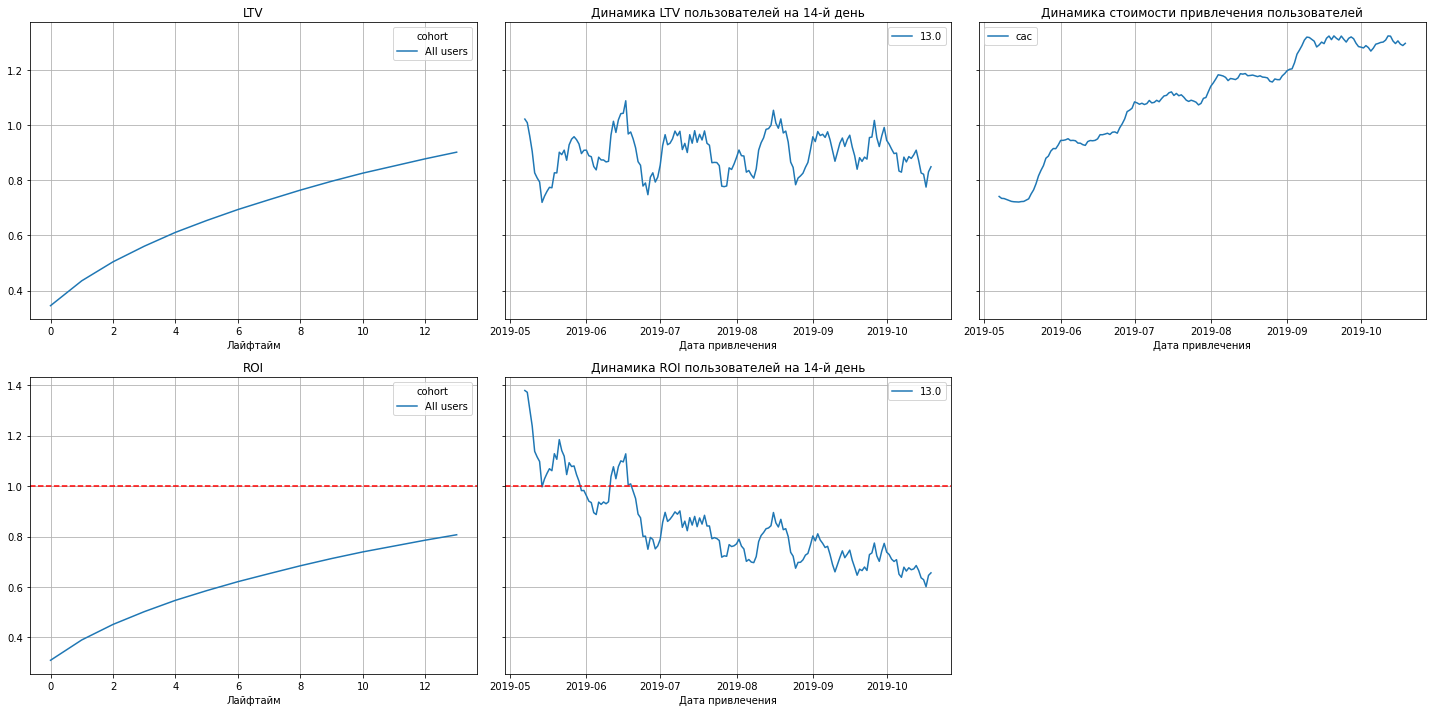

In [34]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:
 - Реклама не окупается. ROI в конце двух недель почти 100%. Но все-таки не 100%.
 - CAC растет, значит рекламный бюджет увеличивается.
 - LTV стабилен.

Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания

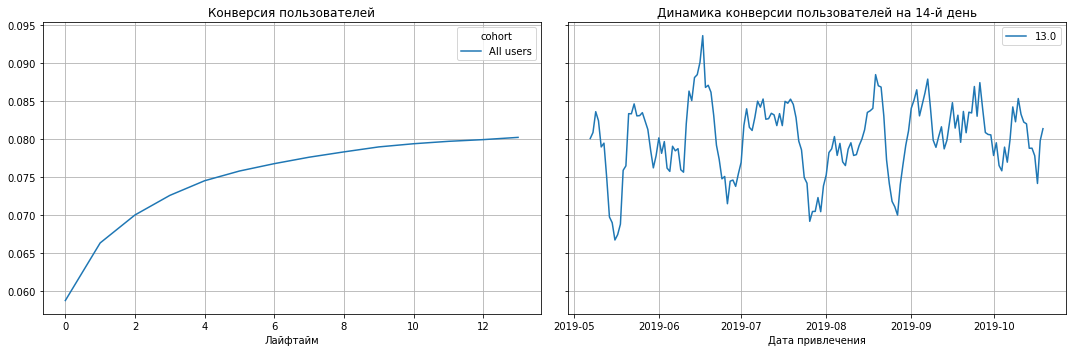

In [35]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_org,
    orders,
    observation_date,
    horizon_days
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия пользователей на второй день составляет 7 %. На 14 - 8%. Конверсия пользователей, привлеченных в середине месяца значительно выше чем в конце. За исключением мая - у пользователей, привлеченных в середине мая, самая низкая конверсия.

Посмотрим на конверсию пользователей по каналам привлечения, по устройствам и странам

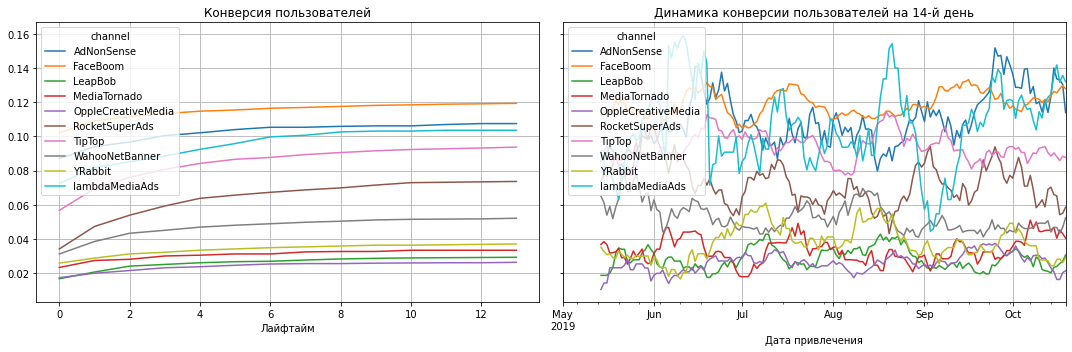

In [36]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_org,
    orders,
    observation_date,
    horizon_days,
    dimensions = ['channel']
)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

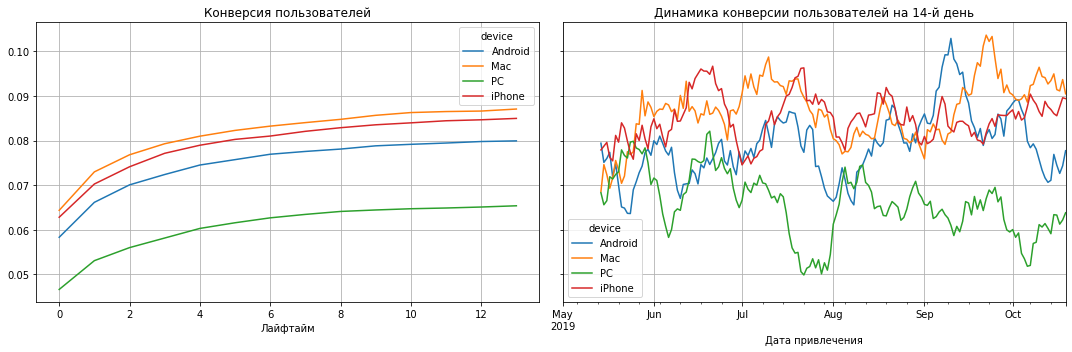

In [37]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_org,
    orders,
    observation_date,
    horizon_days,
    dimensions = ['device']
)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

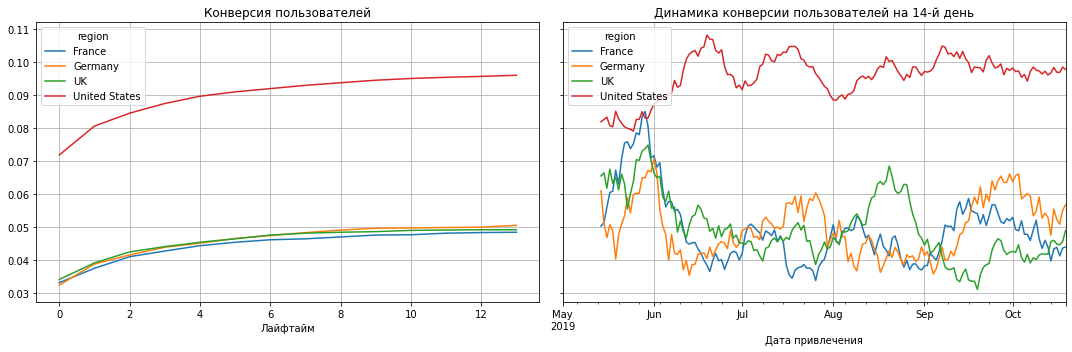

In [38]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_org,
    orders,
    observation_date,
    horizon_days,
    dimensions = ['region']
)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

Конверсия с разбивкой по странам самая красноречивая. У пользователей из США самый высокий уровень конверсии

Посмотрим на удержание пользователей. Построим и изучим графики удержания

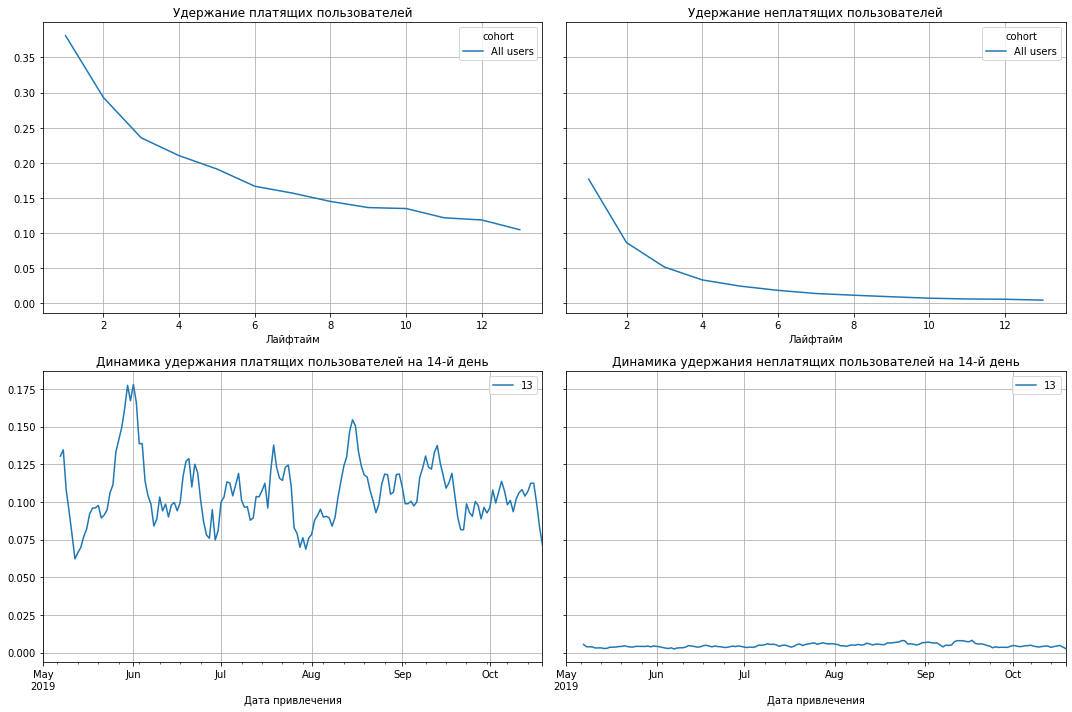

In [39]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no_org,
    visits,
    observation_date,
    horizon_days
)
plot_retention(retention_grouped, retention_history, horizon_days)

Удержание платящих пользователей существенно выше чем неплатящих. В конце мая, начале июня - пик удержания. Динимика удержания неплатящих пользователей стабильно низкая и приближается к нулю. 

Посмотрим на удержание по каналам, странам, устройствам

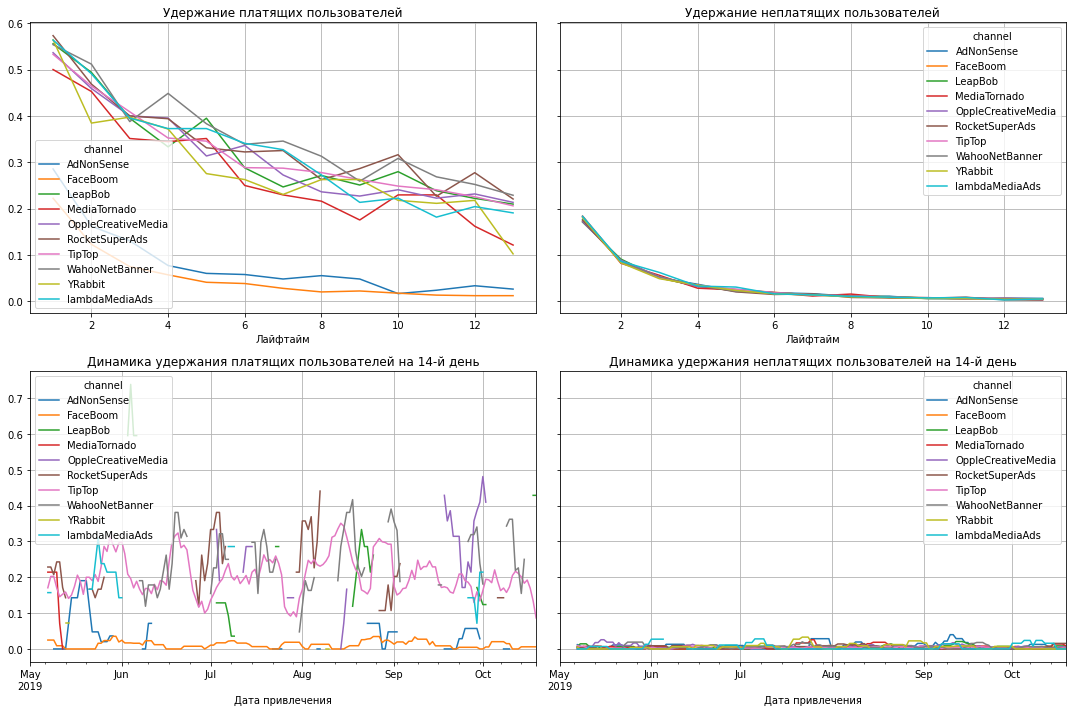

In [40]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no_org,
    visits,
    observation_date,
    horizon_days,
    dimensions = ['channel']
)
plot_retention(retention_grouped, retention_history, horizon_days)

Посмотрим на удержание по каналам, разбив пользователей на пришедших из TipTop, FaceBoom и остальных

In [41]:
profiles_tip_face = profiles_no_org.query('channel in ("TipTop", "FaceBoom")')
profiles_not_tip_face = profiles_no_org.query('channel not in ("TipTop", "FaceBoom")')

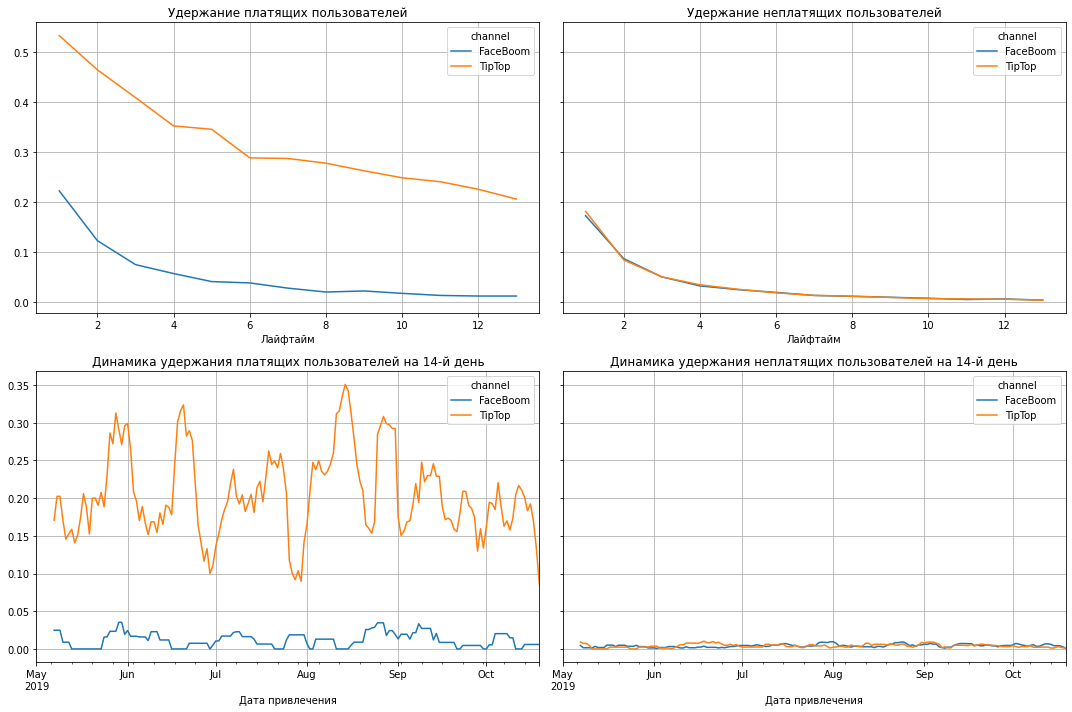

In [42]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_tip_face,
    visits,
    observation_date,
    horizon_days,
    dimensions = ['channel']
)
plot_retention(retention_grouped, retention_history, horizon_days)

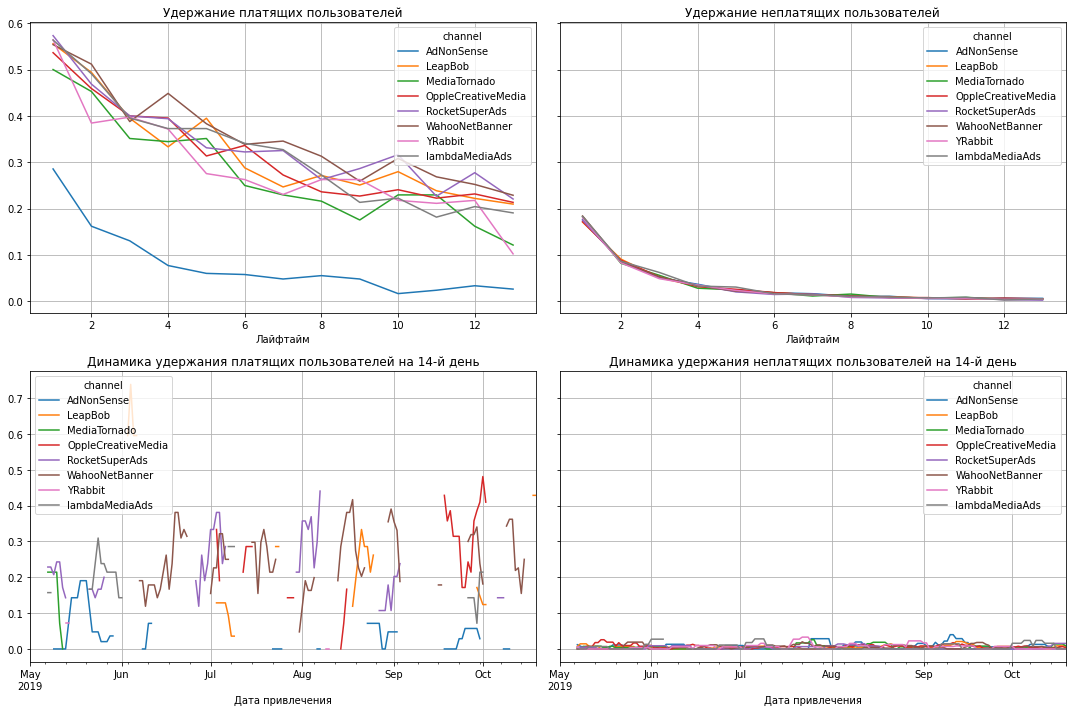

In [43]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_not_tip_face,
    visits,
    observation_date,
    horizon_days,
    dimensions = ['channel']
)
plot_retention(retention_grouped, retention_history, horizon_days)

Удержание пользователей FaceBoom и AdNonSense ниже пользователей, пришедших из других каналов. С динамикой вообще все непонятно. Пользователи только из двух каналов (FaceBoom, TipTop) за анализируемый период доживали до 14 дня 

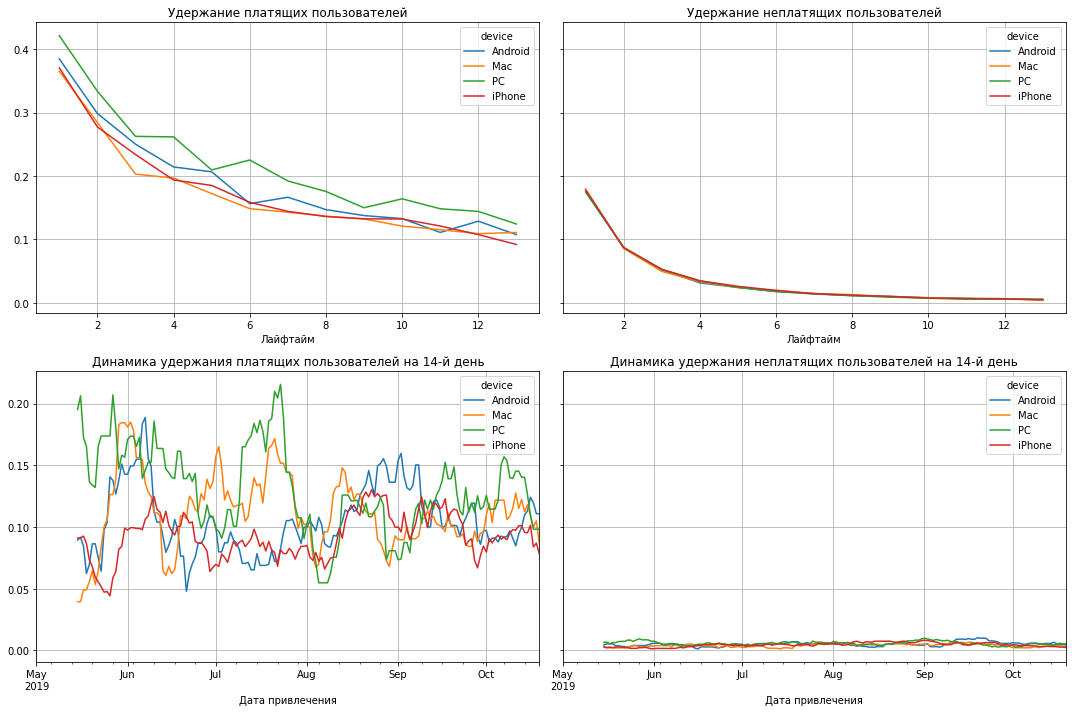

In [44]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no_org,
    visits,
    observation_date,
    horizon_days,
    dimensions = ['device']
)
plot_retention(retention_grouped, retention_history, horizon_days, window=15)

удержание по устройствам - все стабильно. 

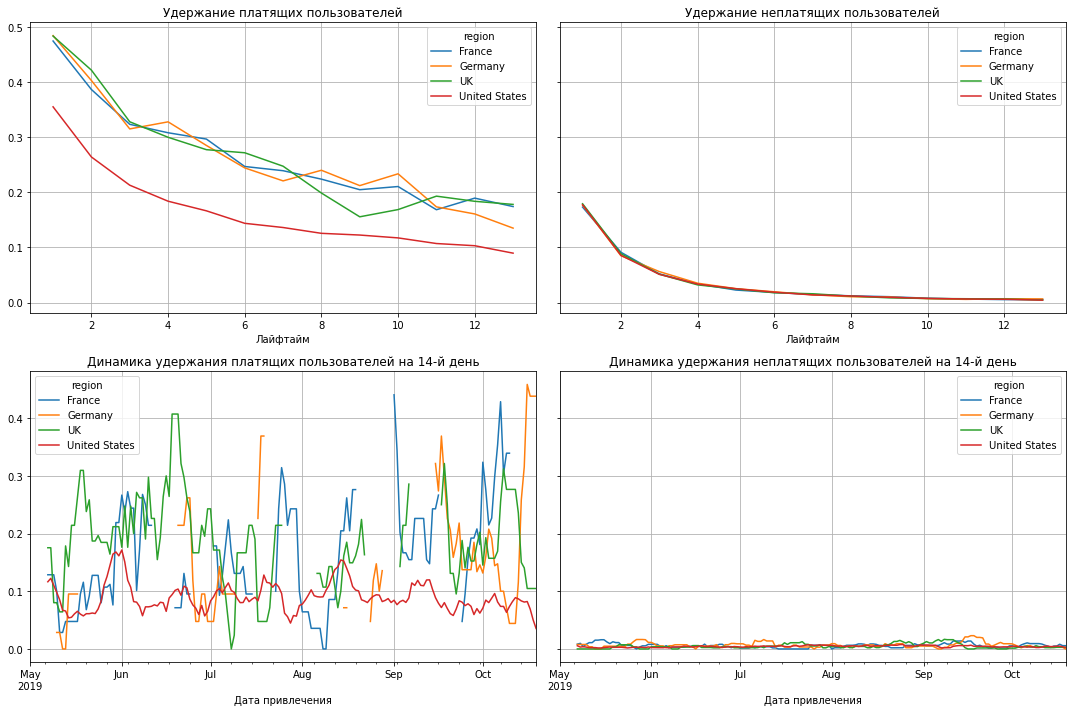

In [45]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no_org,
    visits,
    observation_date,
    horizon_days,
    dimensions = ['region']
)
plot_retention(retention_grouped, retention_history, horizon_days)

Пользователи из США удерживаются хуже всех.

Проанализируем окупаемость рекламы с разбивкой по каналам привлечения. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI

In [46]:
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

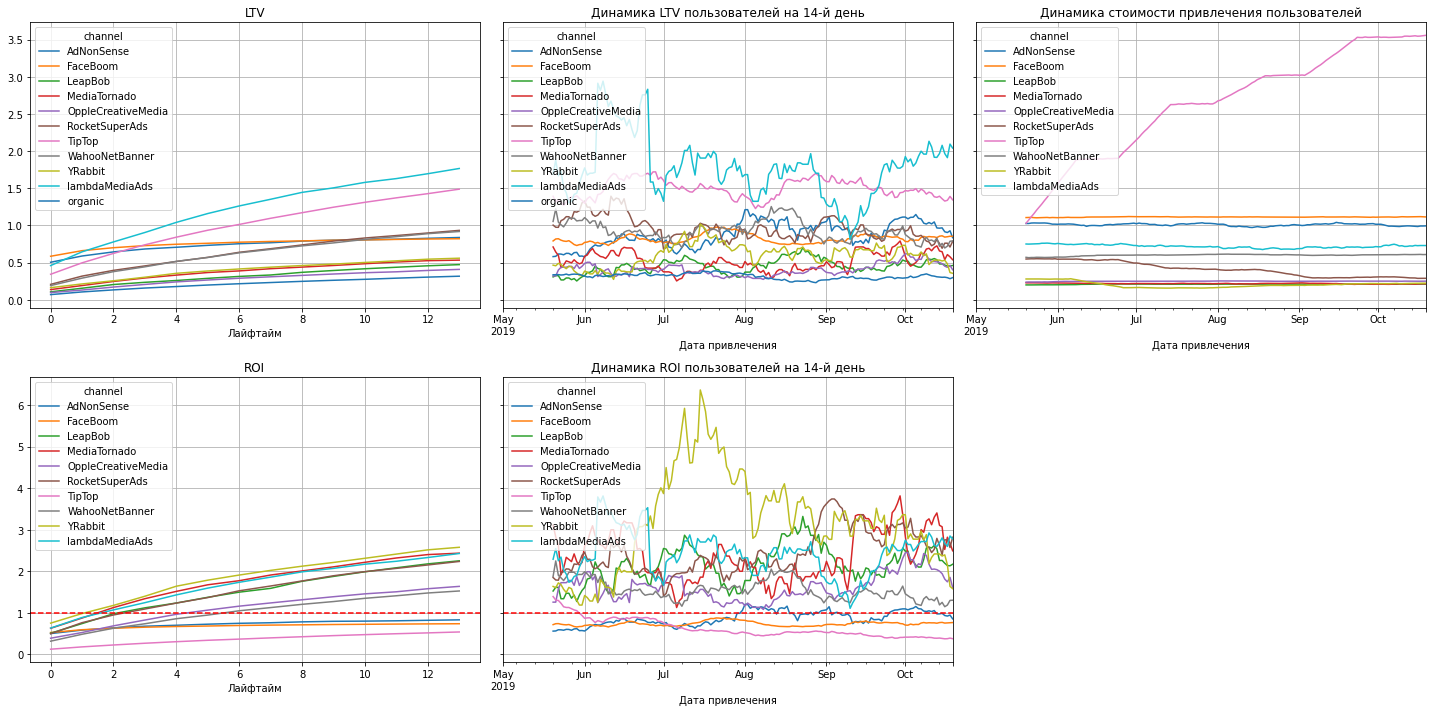

In [47]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=20)

Не окупаются три канала привлечения: TipTop, FaceBoom, AdNonSense. При этом у TipTop увеличивается стоимость привлечения клиентов

Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI

In [48]:
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

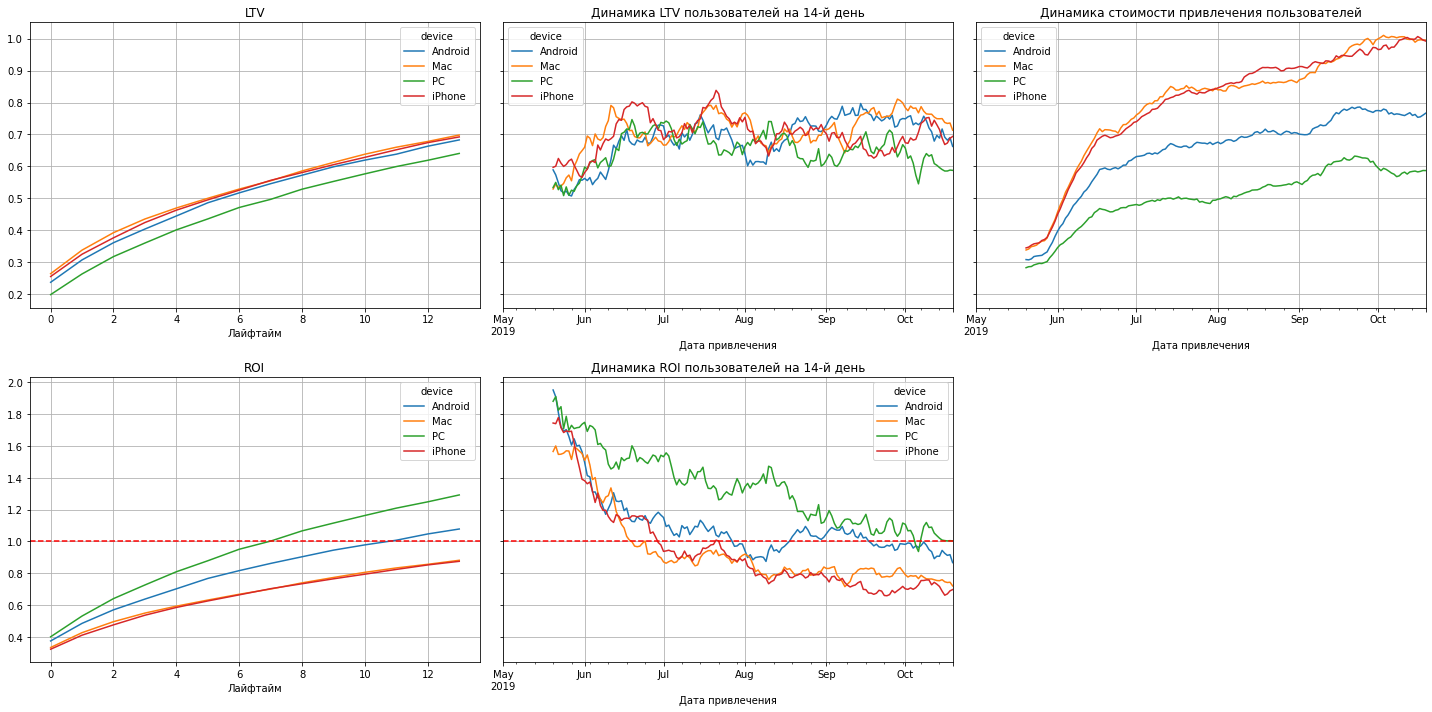

In [49]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=20)

Стоимость привлечения пользователей iPhone и Мас возрастает и не окупается. Стоимость привлечения пользователей Android и РС растет и окупается.

Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI

In [50]:
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

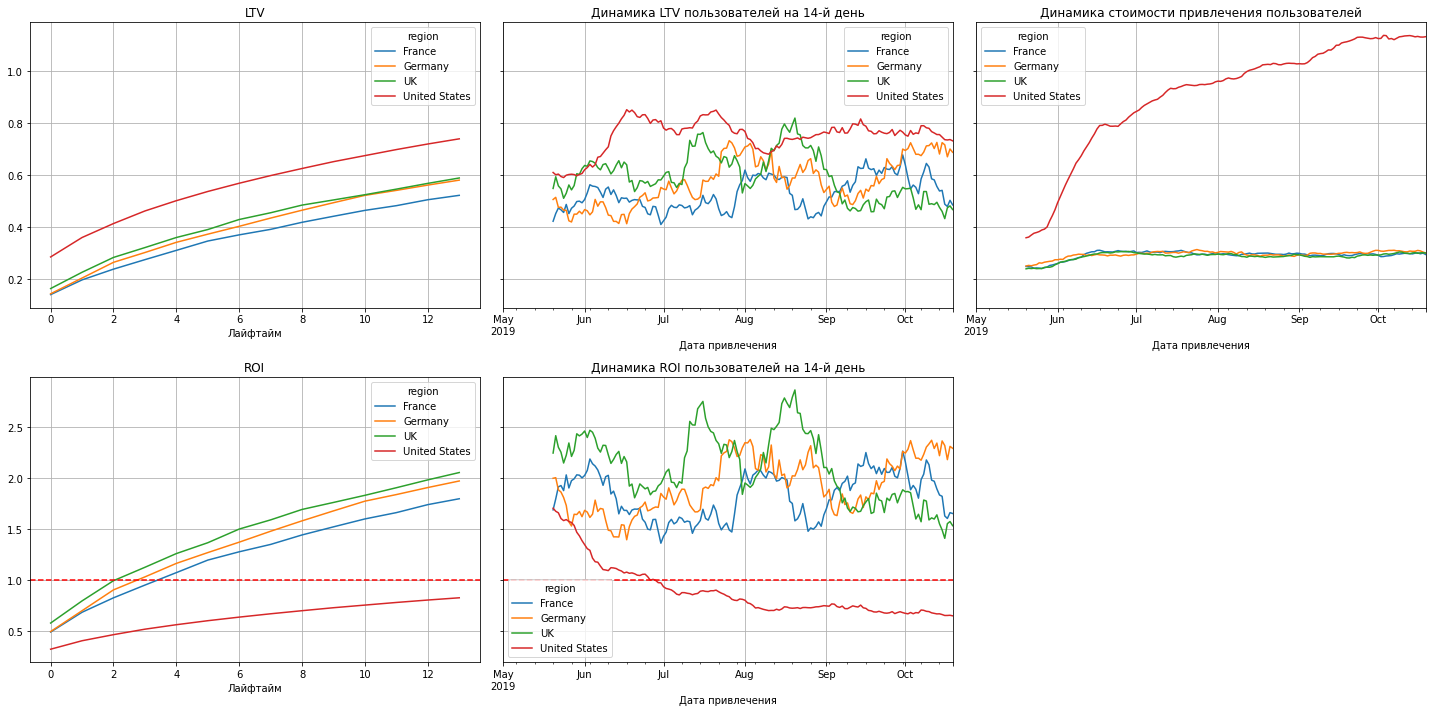

In [51]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=20)

При разбивке по странам сразу выявилась проблема. Клиенты из США выделяются на каждом графике: качество клиентов стабильное и выше чем из других стран, однако траты на рекламу с июня значительно выросли и продолжают увеличиваться, тогда как по другим странам - стабильны. Привлечение клиентов из США не окупается.

Вывод:

**Таким образом причинами неэффективности привлечение пользователей можно назвать следующие:**
 - рост затрат на канал привлечения клиентов - TipTop, который не окупается
 - рост затрат на привлечение клиентов из США, которое не окупается

**Рекомендации для отдела маркетинга:**
 - уменьшить затраты на привлечение клиентов по каналам TipTop, FaceBoom.
 - уменьшить затраты на привлечение пользователей из США
 - увеличение затрат на привлечение клиентов из Германии может быть перспективным
 - привлечение клиентов с помощью канала lambdaMediaAds также может быть перспективным.